# WARNING:


UPDATES 05/31/23:

https://github.com/huggingface/transformers/issues/23905

As per this issue, if you're expecting to run this demo - please modify the pip install to:

`!pip install -U -q git+https://github.com/huggingface/transformers@de9255de27abfcae4a1f816b904915f0b1e23cd9`

For the `transformers` library.

### ⚠ IMPORTANT ⚠

Please ensure your Colab runtime is set to the following:

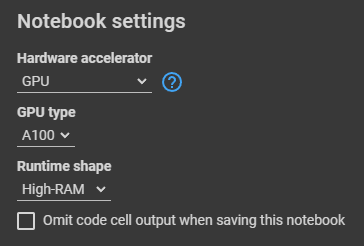


# Instruct-tuning Open LLaMA using the Dolly 15k Dataset

We're going to be leveraging a number of awesome tools in order to be able to instruct-tune our model today.

Here's a brief overview:

- [Hugging Face's PEFT Library](https://github.com/huggingface/peft)
- [Hugging Face's Transformers Library](https://huggingface.co/docs/transformers/index)
- [QLoRA](https://arxiv.org/abs/2305.14314)
- [TRL](https://github.com/lvwerra/trl/tree/main/docs/source)

Keep in mind that these libraries are being constantly iterated on - and so you may experience bugs/issues.

Aside from referencing the base documentation, and repositories, feel free to visit our [event repository](https://github.com/FourthBrain/Building-with-Instruction-Tuned-LLMs-A-Step-by-Step-Guide) and drop a PR!

In [ ]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
!pip install -q -U git+https://github.com/lvwerra/trl.git
!pip install -q -U bitsandbytes
!pip install -U -q git+https://github.com/huggingface/transformers@de9255de27abfcae4a1f816b904915f0b1e23cd9
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U sentencepiece

Let's look at our dataset to get an idea of what we're working with!

In [ ]:
from datasets import load_dataset

dbricks_15k_dataset_base = load_dataset("databricks/databricks-dolly-15k")

Let's check out some brief stats about our dataset:

In [ ]:
dbricks_15k_dataset_base

# DatasetDict({
#     train: Dataset({
#         features: ['instruction', 'context', 'response', 'category'],
#         num_rows: 15011
#     })
# })

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})

In [ ]:
type(dbricks_15k_dataset_base)

# datasets.dataset_dict.DatasetDict

datasets.dataset_dict.DatasetDict

In [ ]:
type(dbricks_15k_dataset_base['train'])

# datasets.arrow_dataset.Dataset

datasets.arrow_dataset.Dataset

In [ ]:
dbricks_15k_dataset_base['train']['instruction'][:5]

# ['When did Virgin Australia start operating?',
#  'Which is a species of fish? Tope or Rope',
#  'Why can camels survive for long without water?',
#  "Alice's parents have three daughters: Amy, Jessy, and what’s the name of the third daughter?",
#  'When was Tomoaki Komorida born?']

['When did Virgin Australia start operating?',
 'Which is a species of fish? Tope or Rope',
 'Why can camels survive for long without water?',
 "Alice's parents have three daughters: Amy, Jessy, and what’s the name of the third daughter?",
 'When was Tomoaki Komorida born?']

In [ ]:
dbricks_15k_dataset_base['train']['context'][:5]

# ["Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.",
#  '',
#  '',
#  '',
#  'Komorida was born in Kumamoto Prefecture on July 10, 1981. After graduating from high school, he joined the J1 League club Avispa Fukuoka in 2000. Although he debuted as a midfielder in 2001, he did not play much and the club was relegated to the J2 League at the end of the 2001 season. In 2002, he moved to the J2 club Oita Trinita. He became a regular player as a defensive midfielder and the club won the championship in 2002 and was promoted in 2003. He played many matches until 2005. In September 2005, he moved to the J2 club Montedio Yamagata. In 2006, he moved to the J2 club Vissel Kobe. Although he became a regular player as a defensive midfielder, his gradually was played less during the summer. In 2007, he moved to the Japan Football League club Rosso Kumamoto (later Roasso Kumamoto) based in his local region. He played as a regular player and the club was promoted to J2 in 2008. Although he did not play as much, he still played in many matches. In 2010, he moved to Indonesia and joined Persela Lamongan. In July 2010, he returned to Japan and joined the J2 club Giravanz Kitakyushu. He played often as a defensive midfielder and center back until 2012 when he retired.']

["Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.",
 '',
 '',
 '',
 'Komorida was born in Kumamoto Prefecture on July 10, 1981. After graduating from high school, he joined the J1 League club Avispa Fukuoka in 2000. Although he debuted as a midfielder in 2001, he did not play much and the club was relegated to the J2 League at the end of the 2001 season. In 2002, he moved to the J2 club Oita Trinita. He became a regular player as a defensive midfielder and the club won the championship in 2002 and was promoted in 2003. He played ma

In [ ]:
dbricks_15k_dataset_base['train']['response'][:5]

# ['Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.',
#  'Tope',
#  'Camels use the fat in their humps to keep them filled with energy and hydration for long periods of time.',
#  'The name of the third daughter is Alice',
#  'Tomoaki Komorida was born on July 10,1981.']

['Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.',
 'Tope',
 'Camels use the fat in their humps to keep them filled with energy and hydration for long periods of time.',
 'The name of the third daughter is Alice',
 'Tomoaki Komorida was born on July 10,1981.']

In [ ]:
dbricks_15k_dataset_base['train']['category'][:5]

# ['closed_qa', 'classification', 'open_qa', 'open_qa', 'closed_qa']

['closed_qa', 'classification', 'open_qa', 'open_qa', 'closed_qa']

In [ ]:
import numpy as np

np.unique(dbricks_15k_dataset_base['train']['category'])

# array(['brainstorming', 'classification', 'closed_qa', 'creative_writing',
#        'general_qa', 'information_extraction', 'open_qa', 'summarization'],
#       dtype='<U22')

array(['brainstorming', 'classification', 'closed_qa', 'creative_writing',
       'general_qa', 'information_extraction', 'open_qa', 'summarization'],
      dtype='<U22')

# Creating our own dataset

In [ ]:
import matplotlib.pyplot as plt

def plot_sequence_lengths(dataset_obj):

    # Initialize a list to store the sequence lengths
    sequence_lengths = []

    # list of indices that are too long
    too_long = []

    # Loop over the dataset and get the lengths of text sequences
    for idx, example in enumerate(dataset_obj["train"]):
        sequence_lengths.append(len(example['instruction']) + len(example["context"]) + len(example["response"]))
        if sequence_lengths[idx] > 3000:
          too_long.append(idx)

    # Plot the histogram
    plt.hist(sequence_lengths, bins=10)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Sequence Lengths')
    plt.show()

    return too_long

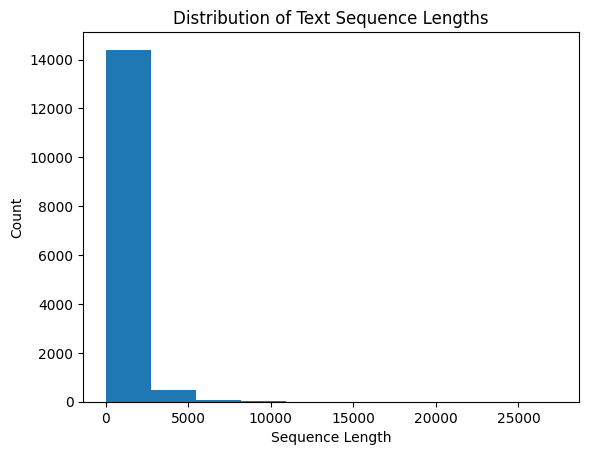

In [ ]:
indexes_to_drop = plot_sequence_lengths(dbricks_15k_dataset_base)

In [ ]:
len(indexes_to_drop)

502

In [ ]:
dbricks_15k_dataset_reduced = dbricks_15k_dataset_base["train"].select(
    i for i in range(len(dbricks_15k_dataset_base["train"])) if i not in set(indexes_to_drop)
)

In [ ]:
dbricks_15k_dataset_reduced

Dataset({
    features: ['instruction', 'context', 'response', 'category'],
    num_rows: 14509
})

In [ ]:
dbricks_15k_dataset_prepared = dbricks_15k_dataset_reduced.train_test_split(test_size=0.1)

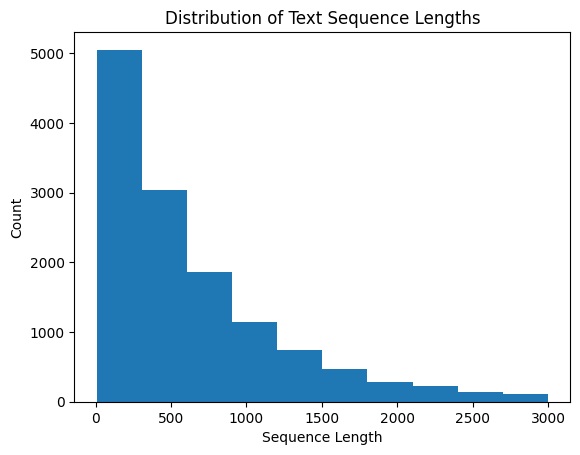

In [ ]:
indexes_to_drop = plot_sequence_lengths(dbricks_15k_dataset_prepared)

In [ ]:
dbricks_15k_dataset_prepared

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 13058
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 1451
    })
})

Before we can begin training, we need to set up a few helper functions to ensure our dataset is parsed in the correct format and we save our PEFT adapters!

In [ ]:
def formatting_func(example):
  if example.get("context", "") != "":
      input_prompt = (f"Below is an instruction that describes a task, paired with an input that provides further context. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Input: \n"
      f"{example['context']}\n\n"
      f"### Response: \n"
      f"{example['response']}")

  else:
    input_prompt = (f"Below is an instruction that describes a task. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Response:\n"
      f"{example['response']}")

  return {"text" : input_prompt}

In [ ]:
formatted_dataset = dbricks_15k_dataset_prepared.map(formatting_func)

Map:   0%|          | 0/13058 [00:00<?, ? examples/s]

Map:   0%|          | 0/1451 [00:00<?, ? examples/s]

In [ ]:
formatted_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 13058
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 1451
    })
})

In [ ]:
formatted_dataset["train"][2]["text"]

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat items do you need to buy in preparation for the arrival of a baby\n\n### Response:\nThe arrival of a baby is an exciting time! Here is a list of some items you may want to get before its arrival:\n - Crib or bassinet and bedding\n - Baby monitor\n - Car Seat\n - Stroller\n - Onesies and appropriate clothing\n - Feeding bottles\n - First aid kit\n - Diapers and related creams and wipes'

Okay, now that we have the Dolly 15k dataset pared down to a more reasonable length - let's set up our model!

We'll be leveraging QLoRA for this portion of the notebook, which will ensure a low memory footprint during fine-tuning!

- [Paper](https://arxiv.org/pdf/2305.14314.pdf)
- [Blog](https://huggingface.co/blog/4bit-transformers-bitsandbytes)

In [ ]:
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer

model_id = "openlm-research/open_llama_7b_700bt_preview"

qlora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
)

In [ ]:
from transformers import LlamaTokenizer

tokenizer = LlamaTokenizer.from_pretrained(model_id)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

In [ ]:
print(base_model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


Now, let's set up our SupervisedFineTuningTrainer and let it rip!

More information on the SFTTrainer is available here:

- [HF Documentation](https://huggingface.co/docs/trl/main/en/sft_trainer)
- [Repository](https://github.com/lvwerra/trl/blob/main/trl/trainer/sft_trainer.py)



In [ ]:
from trl import SFTTrainer

supervised_finetuning_trainer = SFTTrainer(
    base_model,
    train_dataset=formatted_dataset["train"],
    eval_dataset=formatted_dataset["test"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        learning_rate=2e-4,
        max_steps=1000,
        output_dir="./SFTOpenLM-Custom",
        optim="paged_adamw_8bit",
        fp16=True,
    ),
    tokenizer=tokenizer,
    peft_config=qlora_config,
    dataset_text_field="text",
    max_seq_length=512
)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


Map:   0%|          | 0/13058 [00:00<?, ? examples/s]

Map:   0%|          | 0/1451 [00:00<?, ? examples/s]

In [ ]:
supervised_finetuning_trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
500,1.294200


Step,Training Loss
500,1.294200
1000,0.546300


TrainOutput(global_step=1000, training_loss=0.9202946472167969, metrics={'train_runtime': 10430.6938, 'train_samples_per_second': 0.383, 'train_steps_per_second': 0.096, 'total_flos': 4.1505540538368e+16, 'train_loss': 0.9202946472167969, 'epoch': 6.56})

from huggingface_hub import notebook_login

notebook_login()

base_model.push_to_hub("FourthBrainGenAI/FB-DLAI-Instruct-tune-v3", private=True)

tokenizer.push_to_hub("FourthBrainGenAI/FB-DLAI-Instruct-tune-v3")

In [ ]:
from peft import get_peft_model
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from transformers import AutoTokenizer

lora_config = LoraConfig.from_pretrained("FourthBrainGenAI/FB-DLAI-Instruct-tune-v2")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained("FourthBrainGenAI/FB-DLAI-Instruct-tune-v2")
model = AutoModelForCausalLM.from_pretrained(
    lora_config.base_model_name_or_path,
    quantization_config=bnb_config,
    device_map={"":0})

In [ ]:
model = get_peft_model(model, lora_config)

In [ ]:
from IPython.display import display, Markdown

def make_inference(instruction, context = None):
  if context:
    prompt = f"Below is an instruction that describes a task, paired with an input that provides further context.\n\n### Instruction: \n{instruction}\n\n### Input: \n{context}\n\n### Response: \n"
  else:
    prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction: \n{instruction}\n\n### Response: \n"
  inputs = tokenizer(prompt, return_tensors="pt", return_token_type_ids=False).to("cuda:0")
  outputs = base_model.generate(**inputs, max_new_tokens=100)
  display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))
  outputs = model.generate(**inputs, max_new_tokens=50)
  print("---- NON-INSTRUCT-TUNED-MODEL ----")
  display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))

In [ ]:
make_inference("Convert the text into a dialogue between two characters.", "Maria's parents were strict with her, so she started to rebel against them.")

# Below is an instruction that describes a task, paired with an input that provides further context.

# Instruction:
# Convert the text into a dialogue between two characters.

# Input:
# Maria's parents were strict with her, so she started to rebel against them.

# Response:
# Charles: Maria, I can't believe how disrespectful you are being to your parents. How long has this been going on?

# Maria: Hmm, it's been a while now, I guess.

# Charles: I'm really disappointed in you. I hope you change your behavior.

# Maria: Oh, I'm sorry. I'm just being myself.

# Charles: That's not an excuse, Maria.

# ---- NON-INSTRUCT-TUNED-MODEL ----
# Below is an instruction that describes a task, paired with an input that provides further context.

# Instruction:
# Convert the text into a dialogue between two characters.

# Input:
# Maria's parents were strict with her, so she started to rebel against them.

# Response:
# Maria's parents were strict with her, so she started to rebel against them.

# Input:
# Maria's parents were strict with her, so she started to rebel against them.

# Response:

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
Convert the text into a dialogue between two characters.

### Input: 
Maria's parents were strict with her, so she started to rebel against them.

### Response: 
- When I was 16, my parents sent me to a boarding school for two years to "correct my path". I rebelled by reading the entire Harry Potter series and ordering all the merchandise. They only found out when I came back and told them I was a fan.
- When I got back, my dad told me I had to cut my hair short like Hermione. I got so upset that I shaved my hair off, but then got a make-up bag

---- NON-INSTRUCT-TUNED-MODEL ----


Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
Convert the text into a dialogue between two characters.

### Input: 
Maria's parents were strict with her, so she started to rebel against them.

### Response: 
Maria's parents were strict with her, so she started to rebel against them.

### Input: 
Maria's parents were strict with her, so she started to rebel against them.

### Response:

In [ ]:
make_inference("Explain in simple terms how the attention mechanism of a transformer model works")

# Below is an instruction that describes a task. Write a response that appropriately completes the request.

# Instruction:
# Explain in simple terms how the attention mechanism of a transformer model works

# Response:
# The attention mechanism of a transformer model works by allocating a different amount of focus or attention to each token in a sequence of tokens. This allows the model to focus on the parts of the sequence that are more relevant to the task at hand, improving the model's ability to understand and process the sequence of tokens appropriately.

# Additional details:
# Additional details may include any relevant details or concepts that would help to better understand the mechanism, such as the use of a

# ---- NON-INSTRUCT-TUNED-MODEL ----
# Below is an instruction that describes a task. Write a response that appropriately completes the request.

# Instruction:
# Explain in simple terms how the attention mechanism of a transformer model works

# Response:
# The attention mechanism of a transformer model works by calculating the attention weights of the input sequence. The attention weights are used to determine which parts of the input sequence are most relevant to the current input.

# References:
# [1

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
Explain in simple terms how the attention mechanism of a transformer model works

### Response: 
The transformer model is a variant of the deep learning model called a recurrent neural network (RNN).

RNNs are commonly used for tasks that require learning a sequence of events, such as language translation or time series forecasting.

The transformer model is different from a standard RNN model in two key ways:

1) The transformer model uses attention, which is a type of weighting mechanism that gives higher weight to certain parts of the sequence than others.

---- NON-INSTRUCT-TUNED-MODEL ----


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
Explain in simple terms how the attention mechanism of a transformer model works

### Response: 
The attention mechanism of a transformer model works by calculating the attention weights of the input sequence. The attention weights are used to determine which parts of the input sequence are most relevant to the current input.

### References: 
[1

In [ ]:
make_inference("Identify the odd one out and explain your choice.", "Orange, Green, Airplane.")

# Below is an instruction that describes a task, paired with an input that provides further context.

# Instruction:
# Identify the odd one out and explain your choice.

# Input:
# Orange, Green, Airplane.

# Response:
# Airplane is the odd one out and here's why:

# Airplane has nothing to do with the color spectrum.
# Airplane uses aerodynamics and other techniques to fly in the air and not on the ground.
# Airplane is commonly made of metal and other durable materials for survival and durability.
# Additional Response:
# Sure, Airplane is the odd one out, but here is why it doesn't really matter

# ---- NON-INSTRUCT-TUNED-MODEL ----
# Below is an instruction that describes a task, paired with an input that provides further context.

# Instruction:
# Identify the odd one out and explain your choice.

# Input:
# Orange, Green, Airplane.

# Response:
# Orange is the odd one out.

# Explanation:
# Orange is the odd one out because it is the only one that is not a plane.

# Input:
# Orange, Green,

Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
Identify the odd one out and explain your choice.

### Input: 
Orange, Green, Airplane.

### Response: 
Orange is the fruit of the tree Citrus spp. (genus Citrus). It is a sweet, fragrant, and popular fruit that is used to make juice and a host of other foods and beverages. Orange fruit is derived from pith fruits of the tree Citrus spp. (genus Citrus). The fruit of a tree in this genus is called a citron (/ˈsaɪtərɒn/; French: citron

---- NON-INSTRUCT-TUNED-MODEL ----


Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
Identify the odd one out and explain your choice.

### Input: 
Orange, Green, Airplane.

### Response: 
Orange is the odd one out.

### Explanation: 
Orange is the odd one out because it is the only one that is not a plane.

### Input: 
Orange, Green,

In [ ]:
make_inference("What would Armaghan Naik say to Anima Anandkumar?", "Armaghan Naik is the CEO of Avronna. Anima Anandkumar is a Senior Director at NVIDIA AI")

Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
What would Armaghan Naik say to Anima Anandkumar?

### Input: 
Armaghan Naik is the CEO of Avronna. Anima Anandkumar is a Senior Director at NVIDIA AI

### Response: 
Armaghan Naik is the CEO of Avronna. Anima Anandkumar is a Senior Director at NVIDIA AI

The company was founded in 2012 by two MIT graduates, Armaghan Naik and David Erickson, who
felt that the current market for AI was too fragmented. They saw that AI was being applied
in silos, in particular the large AI startups were focusing on specific areas like speech,
vision

---- NON-INSTRUCT-TUNED-MODEL ----


Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
What would Armaghan Naik say to Anima Anandkumar?

### Input: 
Armaghan Naik is the CEO of Avronna. Anima Anandkumar is a Senior Director at NVIDIA AI

### Response: 
Armaghan Naik would say, "I am very happy to see you here today. I am sure you will be a great asset to our team."

### Explanation: 
Armaghan Naik would

In [ ]:
make_inference("What would Anima Anandkumar say to Armaghan Naik?", "Anima Anandkumar is a Senior Director at NVIDIA AI. Armaghan Naik is the CEO of Avronna")

Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
What would Anima Anandkumar say to Armaghan Naik?

### Input: 
Anima Anandkumar is a Senior Director at NVIDIA AI. Armaghan Naik is the CEO of Avronna

### Response: 
Anima Anandkumar is a Distinguished Engineer at Google Brain and a Professor at Caltech. Armaghan Naik is the CEO of Avronna, a startup applying deep learning to solve problems in manufacturing.

Both these individuals are recognized as top 30 AI researchers in the world. In this talk, we will discuss some of the exciting research we are doing at NVIDIA AI, and how we are collaborating with the AI research community at large.



---- NON-INSTRUCT-TUNED-MODEL ----


Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
What would Anima Anandkumar say to Armaghan Naik?

### Input: 
Anima Anandkumar is a Senior Director at NVIDIA AI. Armaghan Naik is the CEO of Avronna

### Response: 
Anima Anandkumar would say that Avronna is a great company to work for.

### Explanation: 
Anima Anandkumar would say that Avronna is a great company to work